### Resampling

zmiana czestotliowsci pomiarow dokonanych aparatura medyczna, aby moc przejrzyscie porowynywac wyniki z danymi z garmina
- dane z aparatury medycznej zapisane byly z czestotliwoscia 500hz
- dane z garmina mierzone byly z czestotliwoscia 128hz

W celu dokonania resamplingu wykorzystana zostala biblioteka scipy.

In [1]:
import os
from pathlib import Path

# Automatycznie znajduje plik bez względu na katalog roboczy
current_dir = Path.cwd()
project_root = current_dir if current_dir.name == "Projekt-EKG" else current_dir / "Projekt-EKG"

plik = project_root / "data" / "N38" / "N38_2025-2025-11-14-11-18-06.csv"

# Sprawdzenie czy plik istnieje
if plik.exists():
    print(f"Plik znaleziony: {plik}")
else:
    print(f"Błąd: Plik nie znaleziony: {plik}")
    print(f"Dostępne pliki w {project_root / 'data'}:")
    if (project_root / "data").exists():
        for item in (project_root / "data").rglob("*.csv"):
            print(f"  - {item}")

Plik znaleziony: c:\projpriad\Projekt-EKG\data\N38\N38_2025-2025-11-14-11-18-06.csv


In [2]:
from scipy.signal import resample, butter, filtfilt, freqs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(str(plik))

garmin_frequency = 128
medical_frequency = 500

number_of_new_samples = int(len(df) * (garmin_frequency/medical_frequency))

resampled_data = resample(df, number_of_new_samples)

resampled_df = pd.DataFrame(resampled_data, columns=df.columns)

In [3]:
df.head()
resampled_df.head()

,I,II,III,avR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,-37.737704,-181.507247,-142.264313,113.390574,54.098965,-161.322146,514.233140,45.685481,-74.597264,-136.394586,-121.806274,-113.673710
1,26.101925,-110.604816,-136.148348,45.851422,83.546240,-123.430572,-20.994009,93.334356,140.166753,56.395783,-21.783445,-56.274374
2,39.503358,-109.639089,-148.817050,38.969838,96.573368,-129.435976,126.442320,103.163460,115.026385,38.983081,-43.150229,-54.260010
3,20.899316,-133.364779,-153.385016,59.969399,89.767454,-143.778714,20.936452,119.907043,151.795202,70.576891,-19.049323,-20.674933
4,-13.734064,-154.305268,-139.348234,88.151155,65.666295,-147.509598,86.747553,118.742155,138.523906,62.834217,-9.940883,0.362939


### Filtering data

W celu usuniecia szumów i nie dokladnosci z sygnalu, zastosujemy dwa filtry:
- lowpass, ktory usunie zaklocenia 
- highpass, ktory wyeliminuje elementy takie jak wlpyw oddechu i dzialania maszyny na wyniki

W celu lepszego zrozumienia jak dziaja te filtry, zaprezentuje kilka rozwiazan.

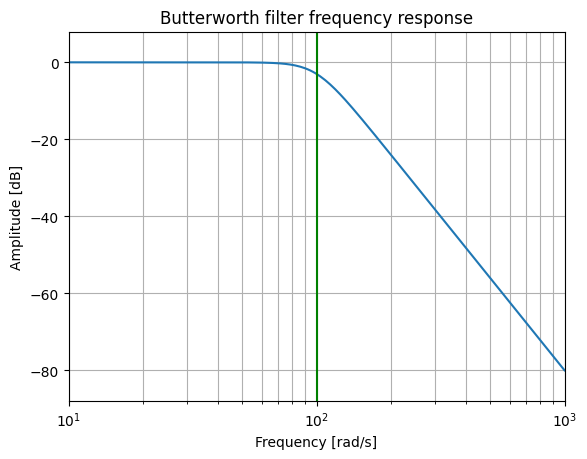

In [4]:
b, a = butter(4, 100, 'low', analog=True)
w, h = freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

Do wyznaczenia wartosci kernela filtra buttera, musimy podac maksymalna mozliwa reprezentowalna czestotliwosc, nazywana czestotliwoscia fouriera. Zapewnia ona brak bledow podczas analizowania sygnalu.
- fourier_frequency = max_frequency / 2

In [5]:
def filter_ekg(signal_data, frequency = 128):
    
    """
    calculating needed frequencies
    """
    
    fourier_frequency = frequency/2
    low_cut = 0.5
    high_cut = 40

    normalized_low_cut = low_cut/fourier_frequency
    normalized_high_cut = high_cut/fourier_frequency

    """
    calculating signal nominators and denominator using butter signal
    """

    b,a = butter(N = 4, Wn=[normalized_low_cut, normalized_high_cut], btype='band')

    filtered_data = filtfilt(b, a, signal_data, axis = 0)

    return filtered_data

clean_data_array = filter_ekg(resampled_df)

clean_df = pd.DataFrame(clean_data_array, columns=resampled_df.columns)
clean_df.head()


,I,II,III,avR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,8.163490,6.572588,-1.641091,-7.374774,4.955663,2.458511,-3.137310,-6.789411,5.802903,-0.159284,7.984383,5.731224
1,69.004100,71.430828,1.422621,-70.311926,34.300103,35.811302,-441.740423,37.098933,190.850416,166.664741,90.908274,53.376699
2,86.646339,76.652082,-11.219074,-81.698460,49.640171,31.970332,-485.564033,57.068649,227.947710,200.963487,101.568735,70.301061
3,60.893942,43.756026,-17.786145,-52.165471,40.145748,12.061081,-399.535483,65.734884,207.837485,182.761141,93.805469,88.817274
4,30.406218,23.865695,-6.787690,-26.955531,19.438585,7.204125,-419.130894,70.087588,218.601922,195.961667,114.654626,112.901901


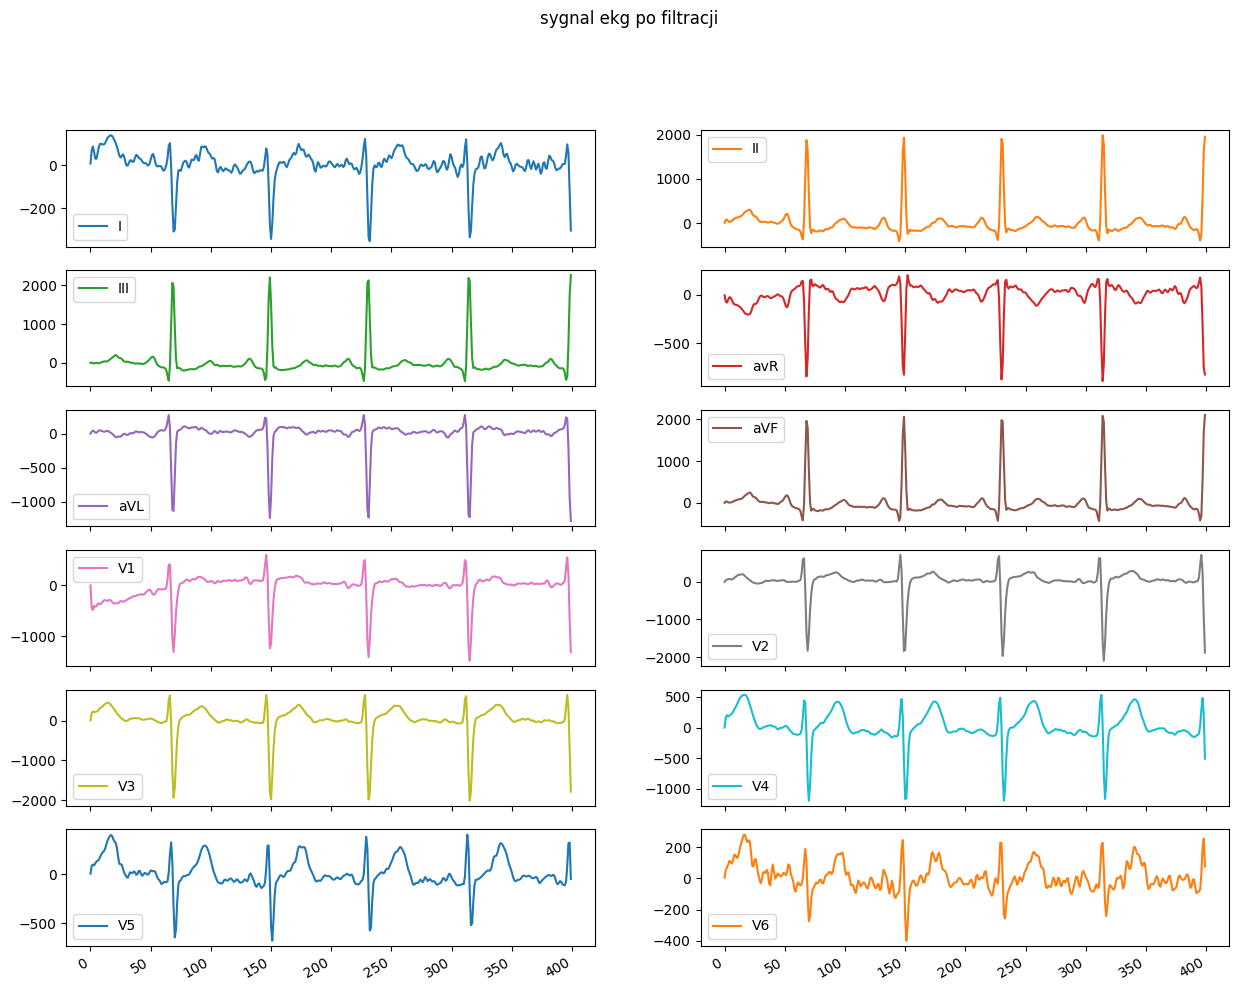

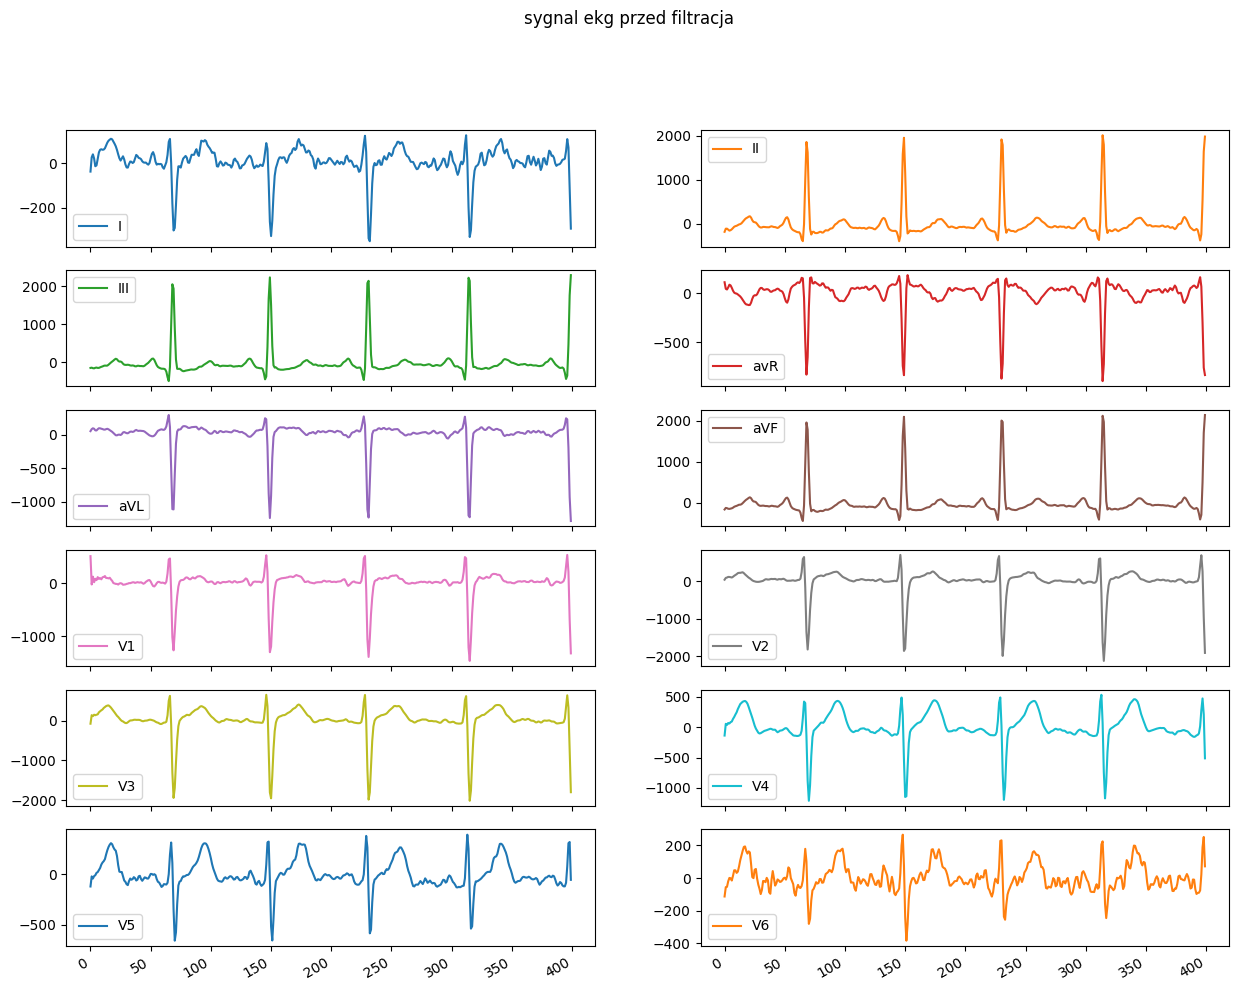

           I         II        III        avR        aVL        aVF  \
0   8.163490   6.572588  -1.641091  -7.374774   4.955663   2.458511   
1  69.004100  71.430828   1.422621 -70.311926  34.300103  35.811302   
2  86.646339  76.652082 -11.219074 -81.698460  49.640171  31.970332   
3  60.893942  43.756026 -17.786145 -52.165471  40.145748  12.061081   
4  30.406218  23.865695  -6.787690 -26.955531  19.438585   7.204125   

           V1         V2          V3          V4          V5          V6  
0   -3.137310  -6.789411    5.802903   -0.159284    7.984383    5.731224  
1 -441.740423  37.098933  190.850416  166.664741   90.908274   53.376699  
2 -485.564033  57.068649  227.947710  200.963487  101.568735   70.301061  
3 -399.535483  65.734884  207.837485  182.761141   93.805469   88.817274  
4 -419.130894  70.087588  218.601922  195.961667  114.654626  112.901901  
           I          II         III         avR        aVL         aVF  \
0 -37.737704 -181.507247 -142.264313  113.390574

In [6]:
subset_clean = clean_df.iloc[:400]
subset_raw = resampled_df[:400]
subset_clean.plot(subplots=True, layout=(6,2), figsize=(15,12), title="sygnal ekg po filtracji")
plt.show()
subset_raw.plot(subplots=True, layout=(6,2), figsize=(15,12), title="sygnal ekg przed filtracja")
plt.show()

print(clean_df.head())
print(resampled_df.head())



### Podzial sygnalu na okna
5 sekund w pryzpadku wolniejszego bicia serca, moze dac nie wystarczajaca ilosc uderzen do celu analizy.
Przy normalnym biciu serca w 10 sekunach, zmiesci sie do 15 uderzen, ta ilosc bedzie wystarczajaca do analizy.
Przy próbkowaniu 128 Hz daje to: 10×128=1280 próbek w oknie.


In [7]:
def create_windows(df, window_seconds=10, step_seconds=5, fs=128):
    

    window_samples = int(window_seconds * fs) 
    step_samples = int(step_seconds * fs)     
    
    data_array = df.values 
    total_samples = data_array.shape[0]
    num_channels = data_array.shape[1]
    
    windows = []
    

    for start_index in range(0, total_samples - window_samples + 1, step_samples):
        end_index = start_index + window_samples
        
        
        window = data_array[start_index:end_index, :]
        windows.append(window)
        
    X = np.array(windows)
    
    return X



W celu dokonania analizy outlierow (anomalii w sygnale) sprobujemy dojrzec je wizualizujac dane na boxplotice

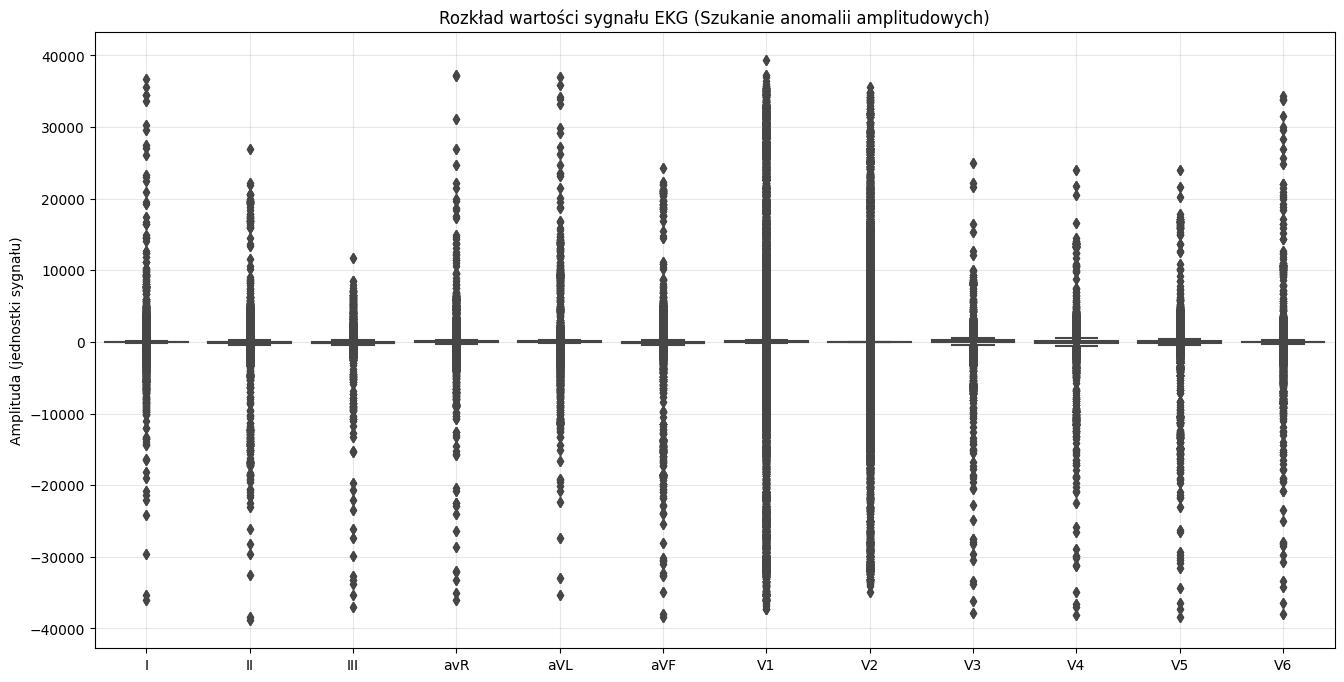

In [8]:
import seaborn as sns


def check_outliers_boxplot(X_data):

    flattened_data = X_data.reshape(-1, 12) 
    

    df_temp = pd.DataFrame(flattened_data, columns=['I','II','III','avR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
    

    plt.figure(figsize=(16, 8))
    

    sns.boxplot(data=df_temp)
    
    plt.title("Rozkład wartości sygnału EKG (Szukanie anomalii amplitudowych)")
    plt.ylabel("Amplituda (jednostki sygnału)")
    plt.grid(True, alpha=0.3)
    plt.show()

X_data = create_windows(clean_df)
check_outliers_boxplot(X_data)

### Wykrywanie anomalii w oknach
jesli odchylenie standardowe aplitud w oknie wynosi okolo zera, oznacza najprawdopodniej prosta linie, dlatego pomijamy te wartosci
jesli maksymalna wartosc w danym oknie wynosi wiecej niz ustalony treshold, w nasyzm przypadku od 3000 do 5000 oznacza wystapienie anomalii, dlatego pomijamy te wartosci.

Window jest rozmiaru (1200, 12) oznacza to ze mamy 1200 wartosci w kazdym z kanalow


In [9]:
import numpy as np

def remove_bad_windows(X, threshold_max_amp=5000, threshold_min_std=1.0):

    
    good_indices = []
    
    
    for i in range(len(X)):
        window = X[i] # Kształt (1280, 12)

        if np.isnan(window).any():
            continue 
            
        stds = np.std(window, axis=0)
        if (stds < threshold_min_std).any():
           
            continue 
            
        max_val = np.max(np.abs(window))
        if max_val > threshold_max_amp:
            continue
            

        good_indices.append(i)
        

    X_clean = X[good_indices]
    
    print(f"Usunięto {len(X) - len(X_clean)} okien.")
    print(f"Pozostało {len(X_clean)} dobrych okien.")
    
    return X_clean

X_final = remove_bad_windows(X_data, threshold_max_amp=3000, threshold_min_std=0.5)

Usunięto 203 okien.
Pozostało 46 dobrych okien.


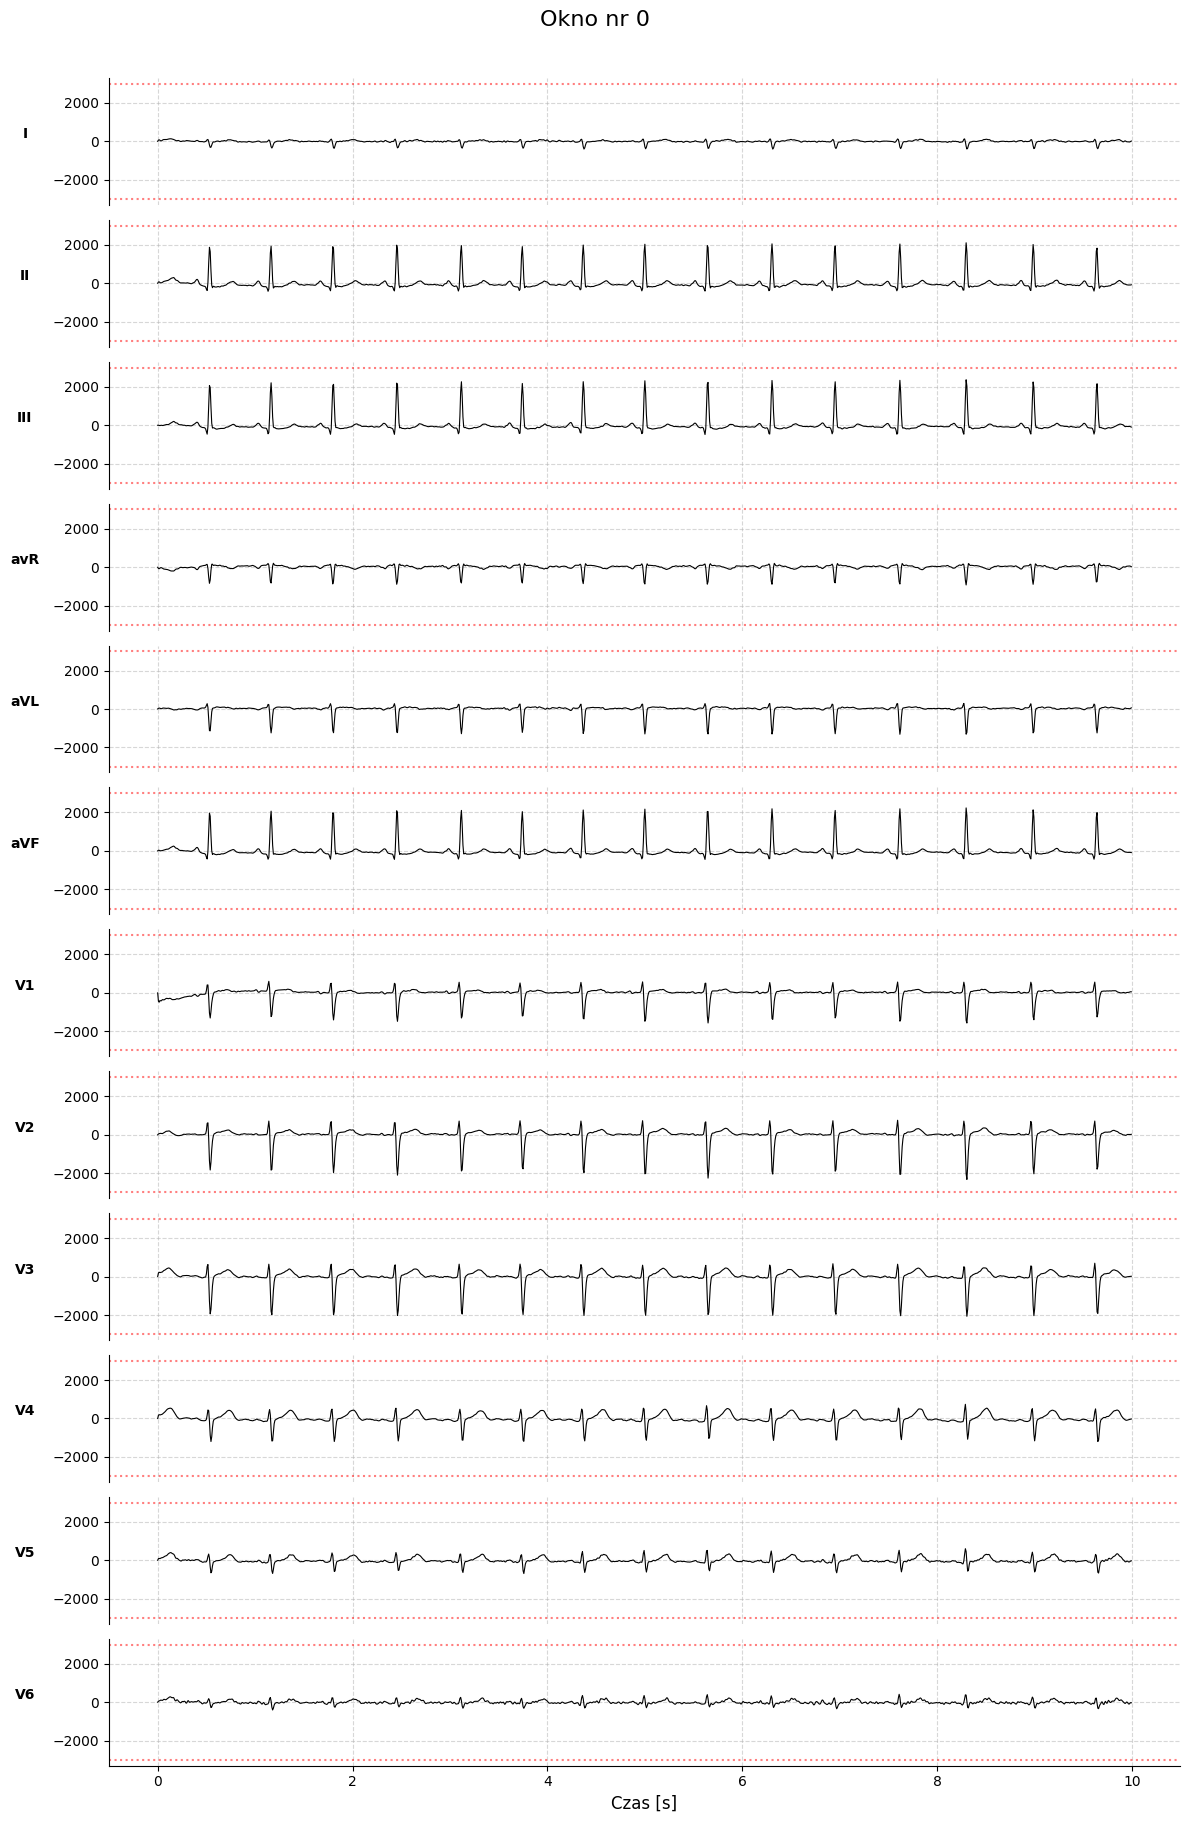

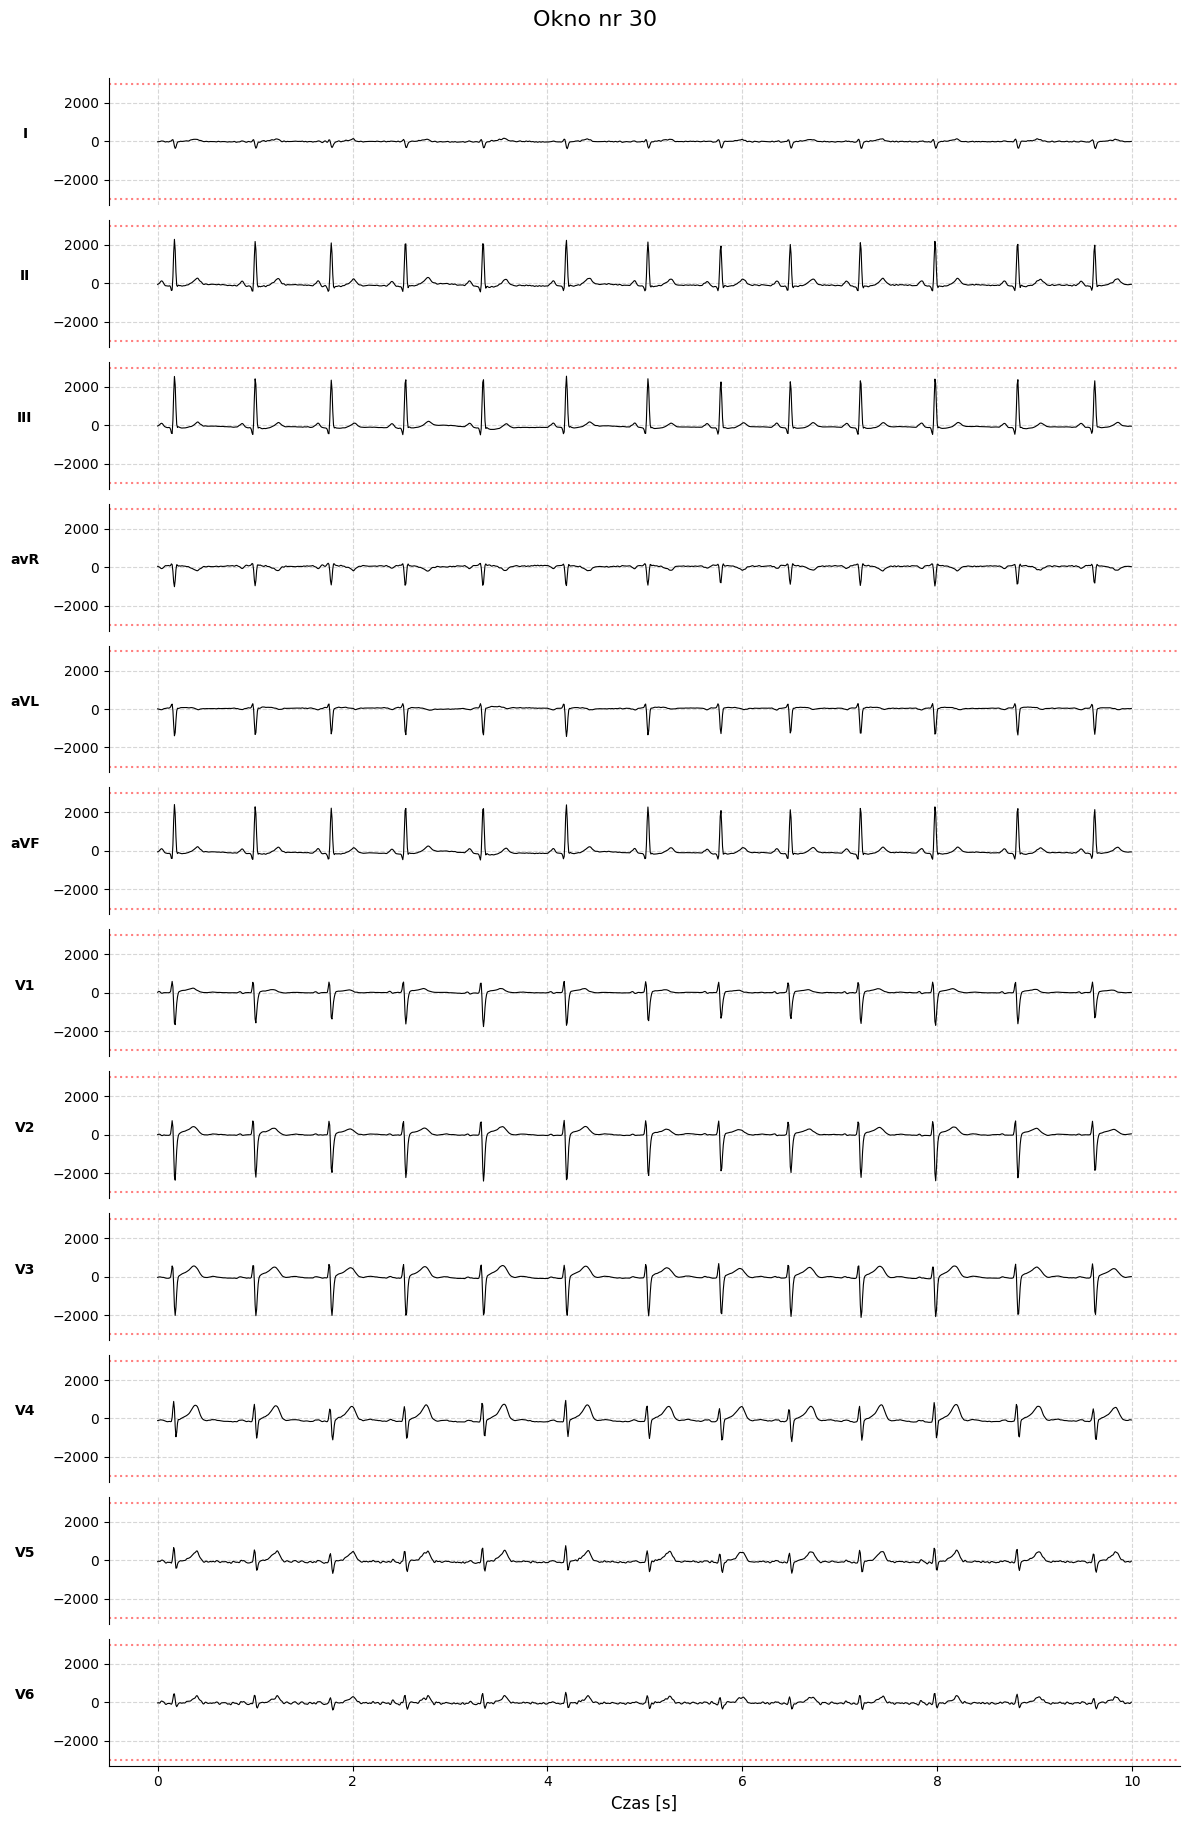

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_window(X_data, window_index, fs=128, threshold=None):
    

    window = X_data[window_index]
    

    time_axis = np.arange(window.shape[0]) / fs
    

    channels = ['I', 'II', 'III', 'avR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    

    fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(12, 18), sharex=True)
    


    for i in range(12):
        ax = axes[i]
        signal = window[:, i]
        
        ax.plot(time_axis, signal, color='black', linewidth=0.8)
        ax.set_ylabel(channels[i], rotation=0, labelpad=20, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # Rysowanie linii progu (jeśli podano)
        if threshold:
            ax.axhline(y=threshold, color='red', linestyle=':', alpha=0.5)
            ax.axhline(y=-threshold, color='red', linestyle=':', alpha=0.5)
            
        # Kosmetyka osi
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i < 11:
            ax.spines['bottom'].set_visible(False)
            ax.tick_params(bottom=False)

    plt.xlabel("Czas [s]", fontsize=12)
    plt.suptitle(f"Okno nr {window_index}", y=1.01, fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_window(X_final, window_index=0, fs=128, threshold=3000)

visualize_window(X_final, window_index=30, fs=128, threshold=3000)

In [11]:

# Zapisujemy przetworzone dane do pliku "pickle" (format pandas zachowujący typy danych) by skorzystać w z3
clean_df.to_pickle("processed_data.pkl")
print("Dane zostały zapisane do pliku 'processed_data.pkl'")

Dane zostały zapisane do pliku 'processed_data.pkl'
